BANKING DEPOSIT SUBSCRIPTION PREDICTION
Loading training data...


[I 2025-05-28 13:24:36,190] A new study created in memory with name: no-name-a0e73362-9d37-417d-a1ad-fd950d66319d



Training Dataset Info:
Rows: 22916, Features: 27
Class Distribution:
{0: 20302, 1: 2614}

Training split: 18332 samples
Validation split: 4584 samples

Starting hyperparameter optimization...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-05-28 13:24:43,716] Trial 0 finished with value: 0.7873198239612261 and parameters: {'algorithm': 'lgb', 'n_estimators': 679, 'max_depth': 4, 'learning_rate': 0.015957084694148364, 'subsample': 0.6232334448672797, 'colsample_bytree': 0.9464704583099741, 'reg_alpha': 0.02537815508265665, 'reg_lambda': 0.06796578090758151, 'num_leaves': 19, 'min_child_samples': 98, 'sampling': 'smote'}. Best is trial 0 with value: 0.7873198239612261.
[I 2025-05-28 13:25:06,350] Trial 1 finished with value: 0.7899741515194466 and parameters: {'algorithm': 'cat', 'iterations': 545, 'depth': 4, 'learning_rate': 0.06252287916406217, 'l2_leaf_reg': 0.0004982752357076451, 'sampling': None}. Best is trial 1 with value: 0.7899741515194466.
[I 2025-05-28 13:25:11,287] Trial 2 finished with value: 0.7896606166884265 and parameters: {'algorithm': 'xgb', 'n_estimators': 674, 'max_depth': 3, 'learning_rate': 0.061721159481070736, 'subsample': 0.6682096494749166, 'colsample_bytree': 0.6260206371941118, 'reg_al

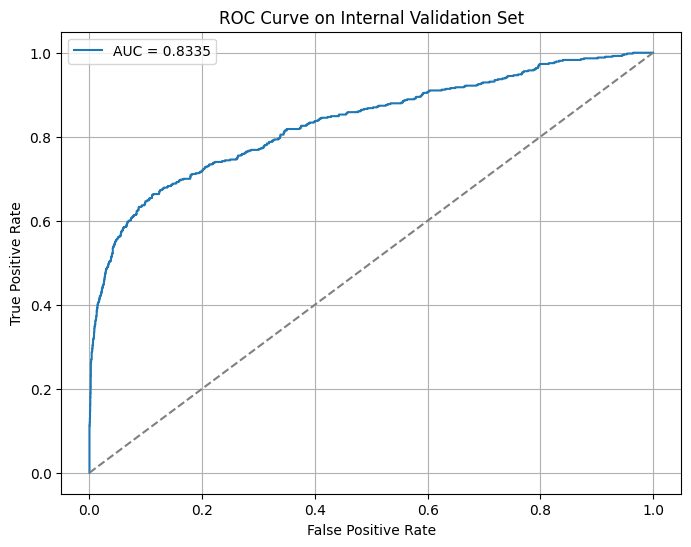


TRAINING COMPLETED
Best AUC: 0.7979
Best Algorithm: cat
Best Sampling: None

FEATURE IMPORTANCE ANALYSIS


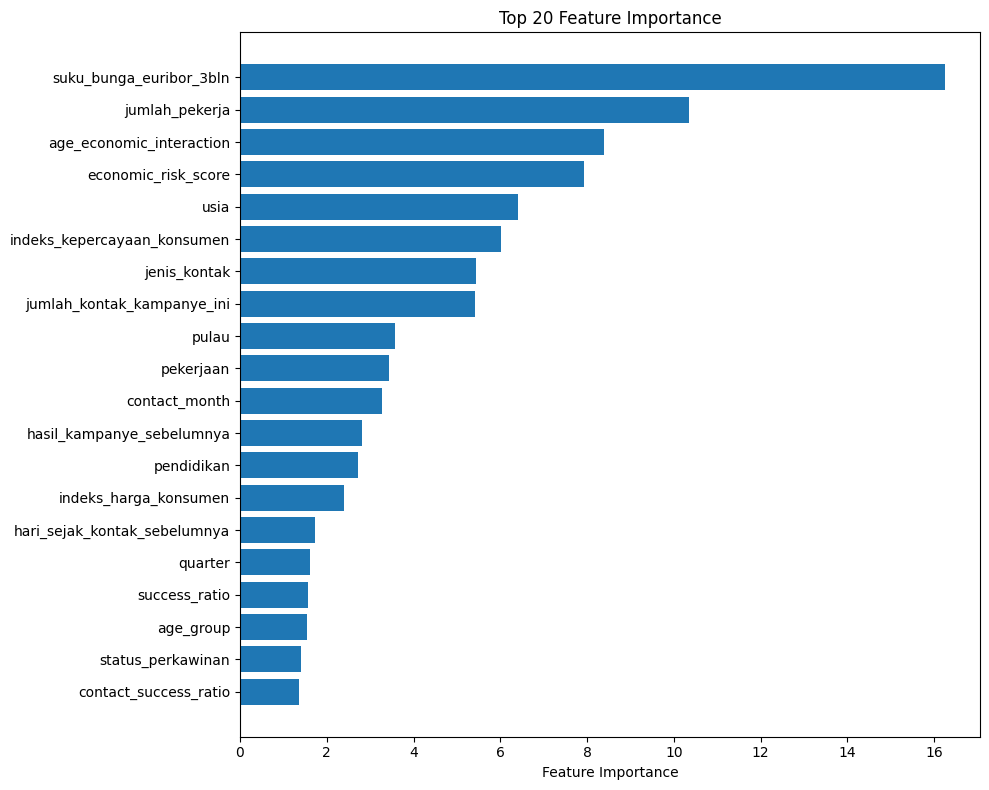


Top 10 Most Important Features:
                    feature  importance
    suku_bunga_euribor_3bln   16.244413
             jumlah_pekerja   10.352055
   age_economic_interaction    8.397538
        economic_risk_score    7.922310
                       usia    6.408697
indeks_kepercayaan_konsumen    6.008407
               jenis_kontak    5.442622
 jumlah_kontak_kampanye_ini    5.420533
                      pulau    3.561831
                  pekerjaan    3.424378

GENERATING PREDICTIONS
Loading validation set for predictions...


In [ ]:
import pandas as pd 
import numpy as np
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, classification_report
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings("ignore")

def create_enhanced_features(data):
    """Sophisticated feature engineering for banking domain"""
    data = data.copy()
    
    # Contact history features
    data['previous_contact_flag'] = np.where(data['hari_sejak_kontak_sebelumnya'] == 999, 0, 1)
    data['success_ratio'] = (
        data['hasil_kampanye_sebelumnya'].map({'success': 1, 'failure': 0, 'nonexistent': 0}) * 
        (data['jumlah_kontak_sebelumnya'] + 1)
    )
    
    # Economic composite features
    economic_features = ['indeks_harga_konsumen', 'suku_bunga_euribor_3bln', 'tingkat_variasi_pekerjaan']
    scaler = StandardScaler()
    data[economic_features] = scaler.fit_transform(data[economic_features])
    data['economic_risk_score'] = (0.4 * data['indeks_harga_konsumen'] + 
                                  0.4 * data['suku_bunga_euribor_3bln'] + 
                                  0.2 * data['tingkat_variasi_pekerjaan'])
    
    # Demographic features
    age_bins = [0, 25, 35, 45, 55, 65, 100]
    data['age_group'] = pd.cut(data['usia'], bins=age_bins, 
                              labels=['18-25', '26-35', '36-45', '46-55', '56-65', '66+'])
    
    # Loan features
    loan_mapping = {'yes': 1, 'no': 0, 'unknown': 0.5}
    data['housing_loan'] = data['pinjaman_rumah'].map(loan_mapping)
    data['personal_loan'] = data['pinjaman_pribadi'].map(loan_mapping)
    
    # Temporal features
    month_map = {'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6,
                'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}
    data['contact_month'] = data['bulan_kontak_terakhir'].map(month_map)
    data['quarter'] = pd.cut(data['contact_month'], 
                            bins=[0,3,6,9,12], 
                            labels=['Q1', 'Q2', 'Q3', 'Q4'])
    
    # Interaction features
    data['contact_success_ratio'] = data['jumlah_kontak_kampanye_ini'] * data['success_ratio']
    data['age_economic_interaction'] = data['usia'] * data['economic_risk_score']
    
    return data

def create_advanced_preprocessor():
    """Create robust preprocessing pipeline with proper categorical handling"""
    
    categorical_features = [
        'pekerjaan', 'status_perkawinan', 'pendidikan', 'gagal_bayar_sebelumnya',
        'pinjaman_rumah', 'pinjaman_pribadi', 'jenis_kontak', 'quarter',
        'hasil_kampanye_sebelumnya', 'pulau', 'age_group'
    ]
    
    numerical_features = [
        'usia', 'jumlah_kontak_kampanye_ini', 'hari_sejak_kontak_sebelumnya',
        'jumlah_kontak_sebelumnya', 'indeks_harga_konsumen',
        'indeks_kepercayaan_konsumen', 'suku_bunga_euribor_3bln',
        'jumlah_pekerja', 'previous_contact_flag', 'success_ratio',
        'economic_risk_score', 'housing_loan', 'personal_loan',
        'contact_month', 'contact_success_ratio', 'age_economic_interaction'
    ]

    numerical_pipe = Pipeline([
        ('scaler', RobustScaler())
    ])

    categorical_pipe = Pipeline([
        ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
    ])

    preprocessor = ColumnTransformer([
        ('num', numerical_pipe, numerical_features),
        ('cat', categorical_pipe, categorical_features)
    ], remainder='drop')

    return preprocessor, numerical_features + categorical_features

def enhanced_objective(trial, X, y, preprocessor):
    """Optimization objective with proper pipeline integration"""
    
    algorithm = trial.suggest_categorical("algorithm", ["xgb", "lgb", "cat"])
    
    # Algorithm configuration
    if algorithm == "xgb":
        params = {
            'n_estimators': trial.suggest_int("n_estimators", 200, 1000),
            'max_depth': trial.suggest_int("max_depth", 3, 9),
            'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
            'subsample': trial.suggest_float("subsample", 0.6, 1.0),
            'colsample_bytree': trial.suggest_float("colsample_bytree", 0.6, 1.0),
            'reg_alpha': trial.suggest_float("reg_alpha", 1e-4, 1.0, log=True),
            'reg_lambda': trial.suggest_float("reg_lambda", 1e-4, 1.0, log=True),
            'scale_pos_weight': trial.suggest_float("scale_pos_weight", 1, 20),
            'random_state': 42,
            'eval_metric': 'auc',
        }
        model = XGBClassifier(**params)
    elif algorithm == "lgb":
        params = {
            'n_estimators': trial.suggest_int("n_estimators", 200, 1000),
            'max_depth': trial.suggest_int("max_depth", 3, 9),
            'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
            'subsample': trial.suggest_float("subsample", 0.6, 1.0),
            'colsample_bytree': trial.suggest_float("colsample_bytree", 0.6, 1.0),
            'reg_alpha': trial.suggest_float("reg_alpha", 1e-4, 1.0, log=True),
            'reg_lambda': trial.suggest_float("reg_lambda", 1e-4, 1.0, log=True),
            'num_leaves': trial.suggest_int("num_leaves", 15, 255),
            'min_child_samples': trial.suggest_int("min_child_samples", 20, 100),
            'random_state': 42,
            'verbosity': -1,
        }
        model = LGBMClassifier(**params)
    else:
        params = {
            'iterations': trial.suggest_int("iterations", 200, 1000),
            'depth': trial.suggest_int("depth", 3, 8),
            'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
            'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1e-4, 10.0, log=True),
            'random_seed': 42,
            'verbose': False,
        }
        model = CatBoostClassifier(**params)

    # Sampling strategy
    sampler = trial.suggest_categorical("sampling", ["smote", "adasyn", None])
    if sampler == "smote":
        sampler = SMOTE(random_state=42)
    elif sampler == "adasyn":
        sampler = ADASYN(random_state=42)
    else:
        sampler = None

    # Cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []

    for train_idx, valid_idx in skf.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        # Create complete pipeline
        pipeline_steps = [('preprocessor', preprocessor)]
        if sampler:
            pipeline_steps.append(('sampler', sampler))
        pipeline_steps.append(('model', model))
        
        pipeline = ImbPipeline(pipeline_steps)
        pipeline.fit(X_train, y_train)

        # Predict and evaluate
        y_pred = pipeline.predict_proba(X_valid)[:, 1]
        auc_scores.append(roc_auc_score(y_valid, y_pred))

    return np.mean(auc_scores)

def train_optimized_model():
    """Train the model using Optuna with train/validation split"""
    
    print("Loading training data...")
    df_train = pd.read_csv("https://raw.githubusercontent.com/difadlyaulhaq/junk/refs/heads/main/training_dataset.csv")
    df_train = create_enhanced_features(df_train)
    
    preprocessor, features = create_advanced_preprocessor()
    X = df_train[features]
    y = df_train['berlangganan_deposito']
    
    print(f"\nTraining Dataset Info:\nRows: {X.shape[0]}, Features: {X.shape[1]}")
    print(f"Class Distribution:\n{y.value_counts().to_dict()}\n")
    
    # Split data for internal validation
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"Training split: {X_train.shape[0]} samples")
    print(f"Validation split: {X_val.shape[0]} samples")
    
    # Optimize hyperparameters
    print("\nStarting hyperparameter optimization...")
    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(lambda trial: enhanced_objective(trial, X_train, y_train, preprocessor), 
                   n_trials=50, show_progress_bar=True)
    
    print(f"\nBest Trial:")
    print(f"AUC: {study.best_value:.4f}")
    print(f"Params: {study.best_params}")
    
    # Train final model on full training data
    best_params = study.best_params.copy()
    algorithm = best_params.pop('algorithm')
    sampling = best_params.pop('sampling')
    
    # Select the best model
    if algorithm == "xgb":
        model = XGBClassifier(**best_params, random_state=42, eval_metric='auc')
    elif algorithm == "lgb":
        model = LGBMClassifier(**best_params, random_state=42, verbosity=-1)
    else:
        model = CatBoostClassifier(**best_params, random_seed=42, verbose=False)
    
    if sampling == "smote":
        sampler = SMOTE(random_state=42)
    elif sampling == "adasyn":
        sampler = ADASYN(random_state=42)
    else:
        sampler = None

    pipeline_steps = [('preprocessor', preprocessor)]
    if sampler:
        pipeline_steps.append(('sampler', sampler))
    pipeline_steps.append(('model', model))
    final_pipeline = ImbPipeline(pipeline_steps)

    print("\nFitting final model on full training data...")
    final_pipeline.fit(X, y)
    
    # Validate on internal validation set
    print("\nValidating on internal validation set...")
    y_pred_prob = final_pipeline.predict_proba(X_val)[:, 1]
    y_pred_label = final_pipeline.predict(X_val)
    
    auc_score = roc_auc_score(y_val, y_pred_prob)
    print(f"Internal Validation AUC: {auc_score:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred_label))
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve on Internal Validation Set')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return final_pipeline, features, study

def make_predictions_on_validation_set(model, features):
    """Generate predictions for the validation set (test data)"""
    
    print("Loading validation set for predictions...")
    df_val = pd.read_csv("https://raw.githubusercontent.com/difadlyaulhaq/junk/refs/heads/main/validation_set.csv")
    df_val = create_enhanced_features(df_val)
    
    # Handle feature mismatch
    available_features = [f for f in features if f in df_val.columns]
    missing = list(set(features) - set(available_features))
    if missing:
        print(f"Warning: Missing features in validation data: {missing}")
        # Remove missing features from the feature list for prediction
        features = available_features
    
    X_val = df_val[features]
    y_pred_prob = model.predict_proba(X_val)[:, 1]
    
    # Create submission file
    submission = pd.DataFrame({
        'customer_number': df_val['customer_number'],
        'berlangganan_deposito': y_pred_prob
    }).sort_values('customer_number')
    
    submission.to_csv("DCM_DMU_2025_Model_barudak_rambat.csv", index=False)
    print(f"\nPredictions saved to DCM_DMU_2025_Model_barudak_rambat.csv")
    print(f"Submission shape: {submission.shape}")
    print(f"Prediction range: [{y_pred_prob.min():.4f}, {y_pred_prob.max():.4f}]")
    print(f"Mean prediction: {y_pred_prob.mean():.4f}")
    
    return submission

def evaluate_if_labels_available(model, features):
    """Evaluate model if validation set has labels"""
    
    try:
        df_val = pd.read_csv("validation_set.csv")
        if 'berlangganan_deposito' not in df_val.columns:
            print("No target labels in validation set - skipping evaluation")
            return None
            
        df_val = create_enhanced_features(df_val)
        X_val = df_val[features]
        y_val = df_val['berlangganan_deposito']
        
        y_pred_prob = model.predict_proba(X_val)[:, 1]
        y_pred_label = model.predict(X_val)
        
        auc_score = roc_auc_score(y_val, y_pred_prob)
        
        # ROC Curve
        fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        
        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_val, y_pred_prob)
        plt.subplot(1, 2, 2)
        plt.plot(recall, precision, label='PR Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        print(f"\nValidation Set AUC: {auc_score:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_val, y_pred_label))
        
        return auc_score
        
    except Exception as e:
        print(f"Could not evaluate on validation set: {e}")
        return None

def analyze_feature_importance(model, features):
    """Analyze and plot feature importance"""
    
    # Get the trained model from the pipeline
    trained_model = model.named_steps['model']
    
    # Get feature importance
    if hasattr(trained_model, 'feature_importances_'):
        importance = trained_model.feature_importances_
        feature_importance = pd.DataFrame({
            'feature': features,
            'importance': importance
        }).sort_values('importance', ascending=False)
        
        # Plot top 20 features
        plt.figure(figsize=(10, 8))
        top_features = feature_importance.head(20)
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Feature Importance')
        plt.title('Top 20 Feature Importance')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        
        print("\nTop 10 Most Important Features:")
        print(feature_importance.head(10).to_string(index=False))
        
        return feature_importance
    else:
        print("Model does not have feature_importances_ attribute")
        return None

# Main execution
if __name__ == "__main__":
    print("="*60)
    print("BANKING DEPOSIT SUBSCRIPTION PREDICTION")
    print("="*60)
    
    # Train model
    model, features, study = train_optimized_model()
    
    print("\n" + "="*60)
    print("TRAINING COMPLETED")
    print("="*60)
    print(f"Best AUC: {study.best_value:.4f}")
    print(f"Best Algorithm: {study.best_params.get('algorithm', 'Unknown')}")
    print(f"Best Sampling: {study.best_params.get('sampling', 'None')}")
    
    # Analyze feature importance
    print("\n" + "="*60)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("="*60)
    feature_importance = analyze_feature_importance(model, features)
    
    # Make predictions on validation set
    print("\n" + "="*60)
    print("GENERATING PREDICTIONS")
    print("="*60)
    submission = make_predictions_on_validation_set(model, features)
    
    # Try to evaluate if labels are available
    print("\n" + "="*60)
    print("EVALUATION (if labels available)")
    print("="*60)
    final_auc = evaluate_if_labels_available(model, features)
    
    print("\n" + "="*60)
    print("PROCESS COMPLETED SUCCESSFULLY!")
    print("="*60)
    print("Files generated:")
    print("- DCM_DMU_2025_Model_barudak_rambat.csv      : Predictions for validation set")
    if final_auc:
        print(f"- Final validation AUC: {final_auc:.4f}")